In [19]:
module SingleSpinFlip

const NDIMS=2
using Statistics
using Base.Cartesian

# Hop to nearest-neighbor site

function hop(index::CartesianIndex{NDIMS},dir::Int64,lr::Int64,dims::NTuple{NDIMS,Int64}) where {NDIMS}
    # update index
    if (lr==1)
      hop_index= index[dir]==dims[dir] ? 1 : index[dir]+1
    else
      hop_index= index[dir]==1 ? dims[dir] : index[dir]-1
    end
    # generate a new CartesianIndex with updated index
    CartesianIndex(Base.setindex(Tuple(index), hop_index, dir))

end

# Binning + (optionally) bootstrap analysis

using Bootstrap
function bin_bootstrap_analysis(data;min_sample_size=128,func_boot=nothing,n_boot=1000)
    # get total length
    data_size=length(data)
    # chop to closest power of 2
    chopped_data_size=2^floor(Int,log(2,data_size))
    chopped_data=collect(Iterators.take(Iterators.reverse(data),chopped_data_size))
    # full data std
    if func_boot==nothing
        stds=[std(chopped_data)/sqrt(chopped_data_size)]
    else
        # bootstrap
        bs = bootstrap(func_boot,chopped_data, BasicSampling(n_boot))
        stds=[stderror(bs)[1] ]
    end
    bin_size=2
    while min_sample_size < div(chopped_data_size,bin_size)
        # bin size
        length_bin=div(chopped_data_size,bin_size)
        # binned data
        binned=reshape(chopped_data,(bin_size,length_bin))
        mean_binned= mean(binned,dims=1)'
        # bin std
        if func_boot==nothing
            std_bin=std(mean_binned)/sqrt(length_bin)
        else
            # bootstrap
            bs = bootstrap(func_boot,mean_binned, BasicSampling(n_boot))
            std_bin = stderror(bs)[1]
        end
        # double bin size
        bin_size=bin_size*2
        push!(stds,std_bin)
    end
    stds
end

# ## MCMC simulation

# Simulation parameters
mutable struct SimData
    # coupling (in units of T)
    J::Float64
    # size
    L::Int64
    # numbers of measurements
    num_measure::Int64
    # numbers of themalization steps
    num_thermal::Int64
end

# Measurements data

mutable struct MeasureData
    # energy measurement time series
    energy::Array{Float64,1}
    # magnetization
    mag::Array{Float64,1}
end
function MeasureData(sim_data::SimData)
    MeasureData(zeros(sim_data.num_measure),zeros(sim_data.num_measure))
end

# Simulation data structure

mutable struct IsingData
    # simulation data
    sim_data::SimData
    # ising configuration
    ising_lat::Array{Int64,NDIMS}
    # total energy
    total_energy::Int64
    # measurements data
    measure_data::MeasureData
end

# Initialization

function IsingData(sim_data::SimData)
   IsingData(
            sim_data,
            ones(ntuple(k->sim_data.L,NDIMS )),
            NDIMS*sim_data.L^NDIMS,
            MeasureData(sim_data)
        )
end

#  Compute single flip $\Delta E$

function calc_delta_E(ising_lat::Array{Int64,NDIMS},pos::CartesianIndex)
    delta_E=0
    # dims
    for d in 1:NDIMS
        # left right
        for lr in 1:2
            # hop to nn
            nn=hop(pos,d,lr,size(ising_lat))
            # check is the same
            if ising_lat[pos]==ising_lat[nn]
               delta_E-=2
            else
               delta_E+=2
            end
        end
    end
    return delta_E
end

#  Single step

function next_step!(ising_data::IsingData)
    J=ising_data.sim_data.J
    ising_lat=ising_data.ising_lat
    # flip site
    flip_site=rand(CartesianIndices(ising_lat))
    # calculate ratio
    delta_E=calc_delta_E(ising_lat,flip_site)
    ratio=exp(J*delta_E)
    # accept or reject
    if ratio>rand()
        # flip
        ising_lat[flip_site]=-ising_lat[flip_site]
        ising_data.total_energy+=delta_E
    end
end

# Make a measurement

function make_measurement!(ising_data::IsingData,i)
    lat_size=length(ising_data.ising_lat)
    # average magnetization
    ising_data.measure_data.mag[i]=sum(ising_data.ising_lat)/lat_size
    # energy density
    ising_data.measure_data.energy[i]=ising_data.total_energy/lat_size
end

# MCMC run

function run_mcmc(sim_data::SimData)
    ising_data=IsingData(sim_data)
    lat_size=length(ising_data.ising_lat)
    # thermalize
    for i in 1:sim_data.num_thermal
        # sweep
        for j in 1:lat_size
            next_step!(ising_data)
        end
    end
    # measure
    for i in 1:sim_data.num_measure
        # sweep
        for j in 1:lat_size
            next_step!(ising_data)
        end
        make_measurement!(ising_data,i)
    end
    ising_data
end


end

Main.SingleSpinFlip

In [15]:
function exact_energy(beta,L)
    cb=cosh(beta)
    sb=sinh(beta)
    Z=cb^L+sb^L
    (cb^(L-2)+sb^(L-2))*sinh(2*beta)/(2*Z)
end

exact_energy (generic function with 1 method)

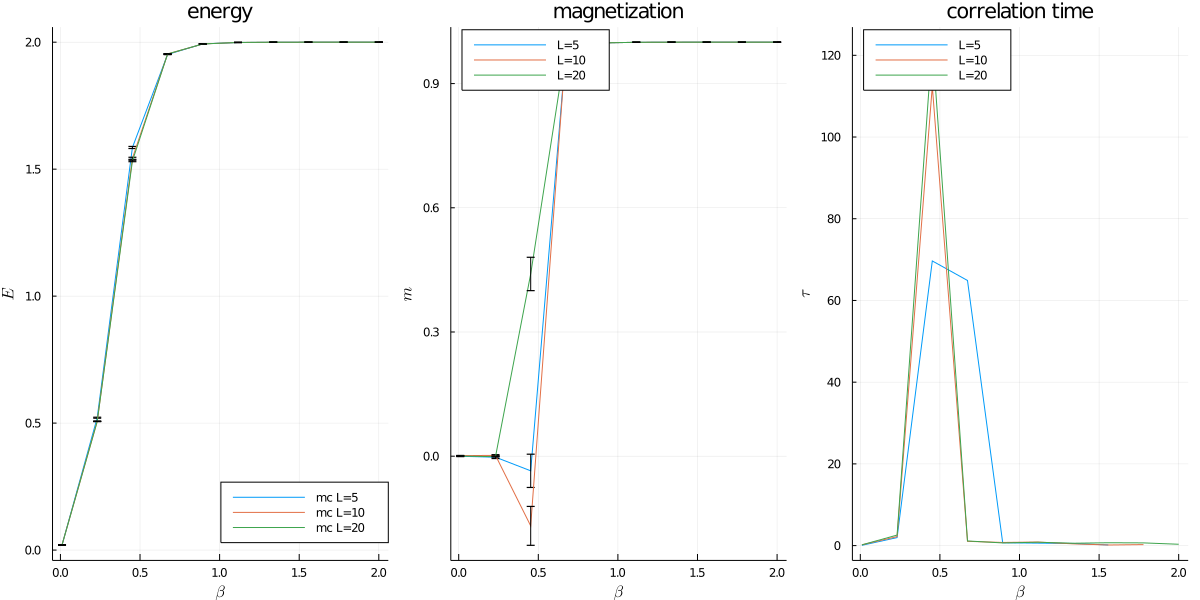

In [21]:
using Plots
using Statistics
using LaTeXStrings
gr()
betas=range(0.01, length=10,stop=2)
Ls=[5,10,20]
num_measure=2^16
num_thermal=1000
fig_en=plot(title="energy")
fig_mag=plot(title="magnetization")
fig_tau=plot(title="correlation time")
for L in Ls
    ens=Float64[]
    ens_std=Float64[]
    mags=Float64[]
    mags_std=Float64[]
    taus=Float64[]
    for b in betas
        sim_data=SingleSpinFlip.SimData(b,L,num_measure,num_thermal)
        res=SingleSpinFlip.run_mcmc(sim_data)
        push!(ens,mean(res.measure_data.energy))
        stds=SingleSpinFlip.bin_bootstrap_analysis(res.measure_data.energy)
        push!(ens_std,stds[end])
        push!(mags,mean(res.measure_data.mag))
        stds=SingleSpinFlip.bin_bootstrap_analysis(res.measure_data.mag)
        push!(mags_std,stds[end])
        tau=0.5*((stds[end]/stds[1])^2-1)
        push!(taus,tau)
    end
    plot!(fig_en,betas,ens,yerr =ens_std,xlabel=L"\beta",ylabel=L"E",label="mc L=$L",legend=:bottomright)
#     plot!(fig_en,betas,[exact_energy(b,L) for b in betas],label="exact L=$L",legend=:bottomright)
    plot!(fig_mag,betas,mags,yerr =mags_std,xlabel=L"\beta",ylabel=L"m",label="L=$L",legend=:topleft)
    plot!(fig_tau,betas,taus,label="L=$L",xlabel=L"\beta",ylabel=L"\tau",legend=:topleft)
end
fig=plot(fig_en,fig_mag,fig_tau,layout=grid(1,3),size = (1200, 600))